## Задача проекта
Проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
* **Тариф «Смарт»**
    * Ежемесячная плата: 550 рублей
    * Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    * Стоимость услуг сверх тарифного пакета:
        * минута разговора: 3 рубля
        * сообщение: 3 рубля
        * 1 Гб интернет-трафика: 200 рублей
        
        
* **Тариф «Ультра»**
    * Ежемесячная плата: 1950 рублей
    * Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    * Стоимость услуг сверх тарифного пакета:
        * минута разговора: 1 рубль
        * сообщение: 1 рубль
        * 1 Гб интернет-трафика: 150 рублей
        
**Примечание**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Описание данных

**Таблица users (информация о пользователях):**

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tariff — название тарифного плана

**Таблица calls (информация о звонках):**

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**

* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

---

## Изучение общей информации о данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns
from scipy import stats as st

In [2]:
#открытие файлов
data_calls=pd.read_csv("C:\\Users\\Полина\\Downloads\\calls.csv")
data_internet=pd.read_csv("C:\\Users\Полина\\Downloads\\internet.csv",index_col=0)
data_messages=pd.read_csv("C:\\Users\\Полина\\Downloads\\messages.csv")
data_tariffs=pd.read_csv("C:\\Users\\Полина\\Downloads\\tariffs.csv")
data_users=pd.read_csv("C:\\Users\\Полина\\Downloads\\users.csv")

In [3]:
#первые строки данных таблиц
print('data_calls')
display(data_calls.head())
print('data_internet')
display(data_internet.head())
print('data_messages')
display(data_messages.head())
print('data_tariffs')
display(data_tariffs.head())
print('data_users')
display(data_users.head())

data_calls


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


data_internet


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


data_messages


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


data_tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


data_users


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [4]:
#общая информация о таблицах
print(data_calls.info())
print()
print(data_internet.info())
print()
print(data_messages.info())
print()
print(data_tariffs.info())
print()
print(data_users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-N

* в данных обнаружены пропуски, а также столбцы с датой в каждом случае имеют тип данных object - тип данных нужно изменить на релевантный (datetime)

In [5]:
#общая информация о значениях в таблицах
print('data_calls')
display(data_calls.describe())
print('data_internet')
display(data_internet.describe())
print('data_messages')
display(data_messages.describe())
print('data_tariffs')
display(data_tariffs.describe())
print('data_users')
display(data_users.describe())

data_calls


,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


data_internet


,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


data_messages


,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


data_tariffs


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


data_users


,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [6]:
#проверка на дубликаты
print(data_calls.duplicated().sum())
print(data_internet.duplicated().sum())
print(data_messages.duplicated().sum())
print(data_tariffs.duplicated().sum())
print(data_users.duplicated().sum())

0
0
0
0
0


### Вывод после изучения общей информации о данных 
* В данных пропуски были обнаружены только в столбце churn_date, так как тариф ещё действовал на момент выгрузки данных.
* Столбцы call_date, message_date,session_date,churn_date, reg_date имеют тип object, значения стоит привести в формат даты и времени.
* Дубликатов обнаружено не было.
* Все данные имеют приемлемые значения, выбросов при первичной обработке обнаружено не было
* Из условия сказано, что данная телеком компания огругляет значения интернет сессий и телефонных звонков, для последующих расчетов данные стоит округлить в большую сторону

---

## Предобработка данных

In [7]:
#приведение данных к нужным типам (дата)
data_calls['call_date']=pd.to_datetime(data_calls['call_date'],format='%Y.%m.%d')
data_internet['session_date']=pd.to_datetime(data_internet['session_date'], format='%Y.%m.%d')
data_messages['message_date']=pd.to_datetime(data_messages['message_date'], format='%Y.%m.%d')
data_users['churn_date']=pd.to_datetime(data_users['churn_date'], format='%Y.%m.%d')
data_users['reg_date']=pd.to_datetime(data_users['reg_date'], format='%Y.%m.%d')

* Округление длительности звонков производится до суммирования. Это согласуется с тем, как оператор фиксирует выручку

In [8]:
#округление значений длительности звонков в большую сторону
data_calls['duration']=data_calls['duration'].apply(np.ceil)

### Вывод о предобработке данных
* Все столбцы со значениями даты были приведены к нужному типу.
* Округлены значения длительности звонков в большую сторону.
*  Нулевые значения длительности звонков(данный звонок означает, что абонент не поднял трубку) остаются для дальнейшего исследования, так как при начислении оплаты тариф начинает действовать с первой секунды, то есть, когда абонент поднял трубку, а в нашем случае стоимость данных звонков с нулевой длительностью будет составлять 0 рублей.

## Расчёты и добавление результатов в таблицу

Для дальнейшего исследования нужно рассчитать помесячные показатели : 

   * количество сделанных звонков каждым пользователем за месяц
   * количество израсходованных минут разговора по месяцам
   * количество отправленных сообщений по месяцам
   * объем израсходованного интернет-трафика по месяцам

In [9]:
#добавление столбцов со значением месяца для расчета значений по месяцам(кол-во звонков, сообщений и т.д)
data_calls['month']=pd.DatetimeIndex(data_calls['call_date']).month
data_messages['month']=pd.DatetimeIndex(data_messages['message_date']).month
data_internet['month']=pd.DatetimeIndex(data_internet['session_date']).month

In [10]:
#количество сделанных звонков каждым пользователем в месяц
data1=data_calls.pivot_table(index=['month','user_id'],aggfunc='count',values='duration')
#переименовываем значение столбца
data1.columns=['calls_count_month']

In [11]:
#количество израсходованных минут разговора по месяцам
data2=data_calls.pivot_table(index=['month','user_id'],aggfunc='sum',values='duration')
#переименовываем значение столбца
data2.columns=['count_min_month']

In [12]:
#количество отправленных сообщений по месяцам
data3=data_messages.pivot_table(index=['month','user_id'],aggfunc='count',values='id')
#переименовываем значение столбца
data3.columns=['message_count_month']

In [13]:
#объем израсходованного интернет-трафика по месяцам;
data4=data_internet.pivot_table(index=['month','user_id'],aggfunc='sum',values='mb_used')
#переименовываем значение столбца
data4.columns=['gb_count_month']

* Для дальнейших выводов значения интернет сессий нужно перевести в гб, а затем окргулить в большую сторону.

In [14]:
#переводим значения столбца из мб в гб
data4['gb_count_month']=(data4['gb_count_month']/1024)
#окгругляем значение интернет сессий в большую сторону
data4['gb_count_month']=(data4['gb_count_month'].apply(np.ceil))

* для удобства объединим все полученные значения в одну таблицу

In [15]:
#объединяем таблицы с вычисленными значениями в одну таблицу
data=data1.join(data2)
data=data.join(data3)
data=data.join(data4).reset_index()
#общая таблица со всеми данными(расчеты по месяцам и личная информация о клиентах)
data=pd.merge(data,data_users)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3174 entries, 0 to 3173
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   month                3174 non-null   int64         
 1   user_id              3174 non-null   int64         
 2   calls_count_month    3174 non-null   int64         
 3   count_min_month      3174 non-null   float64       
 4   message_count_month  2678 non-null   float64       
 5   gb_count_month       3163 non-null   float64       
 6   age                  3174 non-null   int64         
 7   churn_date           187 non-null    datetime64[ns]
 8   city                 3174 non-null   object        
 9   first_name           3174 non-null   object        
 10  last_name            3174 non-null   object        
 11  reg_date             3174 non-null   datetime64[ns]
 12  tariff               3174 non-null   object        
dtypes: datetime64[ns](2), float64(3),

### Вывод о проделанных расчетах
* Были добавлены столбцы со значением месяца для дальнейших расчетов.
* Расчитаны значения по месяцам: количество звонков, количество сообщений, длительность звонков, длительность интернет сессий. Полученные данные были объеденены в одну таблицу с личной информацией о клиенте.
* При изучении полученной таблицы были обнаружены пропуски в столбце message_count_month (пользователи не отправляли сообщения в месяце) и в столбце gb_count_month (не пользовались интернетом за месяц), пропуски нужно заменить нулями.

In [16]:
#заполняем пропуски нулями, когда пользователи не отправляли сообщения за месяц
data['message_count_month'] = data['message_count_month'].fillna(0)
#заполняем пропуски нулями, когда пользователи не пользовались интернетом за месяц
data['gb_count_month'] = data['gb_count_month'].fillna(0)

**Рассчитаем помесячную выручку с каждого пользователя**

In [17]:
#функция для расчета помесячную выручки с каждого пользователя
def price(row):
    if row['tariff']=='smart':
        if row['count_min_month']>500:
            price1=(row['count_min_month']-500)*3
        else:
            price1=0
        if row['message_count_month']>50:
            price2=(row['message_count_month']-50)*3
        else:
            price2=0
        if row['gb_count_month']>15:
            price3=(row['gb_count_month']-15)*200
        else:
            price3=0
        price=price1+price2+price3+550
        
    if row['tariff']=='ultra':
        if row['count_min_month']>3000:
            price1=(row['count_min_month']-3000)*1
        else:
            price1=0
        if row['message_count_month']>1000:
            price2=(row['message_count_month']-1000)*1
        else:
            price2=0
        if row['gb_count_month']>30:
            price3=(row['gb_count_month']-30)*150
        else:
            price3=0
        price=price1+price2+price3+1950
    return price

In [18]:
#помесячная выручка с каждого пользователя
data['revenue']=data.apply(price,axis=1)

* Получена финальная таблица. Стоит убрать из нее излишнюю информацию в виде имени или фамилии клиента. Такая информация никак не поможет в анализе, поэтому хранить ее повторно не стоит. Информация о тарифах уже есть в таблице tariffs. Дублировать ее не стоит. Также выручку стоит сделать целочисленным показателем.

In [19]:
#удаление лишних столбцов из общей таблицы (не применяются в дальнейшей исследовании: имя, фамилия,возраст)
data = data.drop(['age','first_name','last_name'], axis=1)

In [20]:
#приведение столбца revenue(выручка) к целочисленному типу
data['revenue']=data['revenue'].astype('int')

---

##  Анализ данных

In [21]:
print('Среднее количество минут по месяцам')
display(data.pivot_table(index='tariff',columns='month')['count_min_month'])

Среднее количество минут по месяцам


month,1,2,3,4,5,6,7,8,9,10,11,12
tariff,,,,,,,,,,,,
smart,203.852941,298.689655,390.051948,367.133929,387.361702,398.067485,408.353234,423.269231,430.266409,427.590444,436.647619,479.985119
ultra,428.111111,297.125000,489.648649,475.301887,534.250000,497.469136,564.397727,530.611650,558.882883,581.728814,562.364341,614.925373


* Среднее количество минут разговора в тарифе "ULTRA" и "SMART" растет каждый месяц и достигает пика в декабре. Среднее количество минут каждый месяц больше на тарифе "Ultra",исключением является февраль(306(смарт) и 304(ультра) минуты).

In [22]:
print('Среднее количество сообщений по месяцам')
display(data.pivot_table(index='tariff',columns='month')['message_count_month'])

Среднее количество сообщений по месяцам


month,1,2,3,4,5,6,7,8,9,10,11,12
tariff,,,,,,,,,,,,
smart,18.235294,24.086207,31.857143,30.741071,33.773050,33.312883,33.751244,33.709402,33.644788,33.808874,34.120635,35.997024
ultra,33.777778,21.958333,32.297297,32.584906,37.859375,40.049383,48.477273,47.864078,51.810811,58.466102,56.000000,60.753731


* Среднее количество сообщений в тарифе "ULTRA" и "SMART" растет каждый месяц и достигает пика в декабре. Среднее количество отправленных сообщений каждый месяц больше на тарифе "Ultra",исключением является февраль(24(смарт) и 21(ультра) сообщение).

In [23]:
print('Среднее количество гб по месяцам')
data.pivot_table(index='tariff',columns='month')['gb_count_month']

Среднее количество гб по месяцам


month,1,2,3,4,5,6,7,8,9,10,11,12
tariff,,,,,,,,,,,,
smart,8.735294,11.844828,15.233766,13.625000,15.907801,15.969325,15.875622,16.760684,16.389961,16.870307,16.996825,18.205357
ultra,13.222222,12.000000,17.648649,17.528302,19.671875,18.925926,20.443182,19.611650,19.135135,20.093220,19.666667,21.649254


* Среднее количество гб использованного интернета в тарифе "ULTRA" и "SMART" растет каждый месяц и достигает пика в декабре. Среднее количество гб каждый месяц больше на тарифе "Ultra".

**Статистический анализ данных**

In [24]:
#столбцы со значениями таблиц(они не понадобятся при статистическом анализе)
dates=['churn_date','reg_date','month']

In [25]:
#таблица только со значением тарифа ultra
data_ultra=data.drop(dates,axis=1).query('tariff=="ultra"')

#дисперсия
var_ultra='',np.var(data_ultra, ddof=1)
#стандартное отклонение
std_ultra=data_ultra.std()
#среднее
mean_ultra=data_ultra.mean()

In [26]:
#таблица только со значением тарифа smart
data_smart=data.drop(dates,axis=1).query('tariff=="smart"')
#дисперсия
var_smart='',np.var(data_smart, ddof=1)
#стандартное отклонение
std_smart=data_smart.std()
#среднее
mean_smart=data_smart.mean()

In [41]:
#единая таблица со всеми значениями для упарощения стравнения тарифов
analysis = pd.DataFrame({'mean_smart':mean_smart,'mean_ultra':mean_ultra,
                   'std_smart':std_smart,'std_ultra':std_ultra})
analysis

,mean_smart,mean_ultra,std_smart,std_ultra
user_id,1245.904184,1264.766562,145.837842,140.413405
calls_count_month,58.621233,76.016824,25.796101,42.403348
count_min_month,419.062978,545.451104,189.325618,306.925754
message_count_month,33.396311,49.033649,28.259437,46.890656
gb_count_month,16.329735,19.487907,5.752599,9.890432
revenue,1290.891138,2070.977918,819.119853,379.423372


**Из данной таблицы можно сделать вывод**
* Среднее значение звонков по месяцам у тарифа ультра больше, а также больше среднее отклонение, что свидетельсвует о большем разнообразии количества звонков - тарифом пользуется люди, которые звонят как много, так и мало.
* Аналогичная ситуация присуща для всех остальных параметров: суммарной длительности звонков, количеству сообщений, колиечеству потраченных мегабайт.
* Средняя выручка больше у тарифа ультра.
* Стандартное отклонение для показателя - выручка у тарифа смарт в 4 раза больше, чем у тарифа ультра. Это может быть обосновано тем, что существуют пользователи, которые пользуются тарифом смарт и не превышают включенные услуги, а существуют те, кто превышает - а значит, доплачивают, и доплачивают больше, чем такой же пользователь тарифа ультра, так как стоимость услуг сверх пакета больше.
* Вышесказанное подтверждает  то, что ежемесячная стоимость подписки смарт - 550 рублей, а средняя выручка на одного пользователя составляет 1290 рублей.
* Ежемесячная стоисомть тарифа ультра - 1950 рублей, а средняя выручка -2070 рублей, это означает, что для большинства пользователей услуги сверх тарифного плана не актуальны.

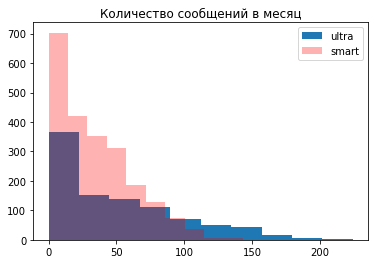

In [28]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(data_ultra['message_count_month'].values)
_ = ax.hist(data_smart['message_count_month'].values, color='red', alpha=.3)
_ = ax.legend(['ultra', 'smart'])
_ = ax.set_title('Количество сообщений в месяц')

<AxesSubplot:>

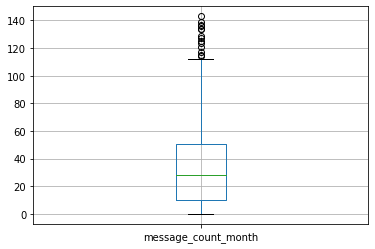

In [29]:
data_smart.boxplot(column ='message_count_month')

<AxesSubplot:>

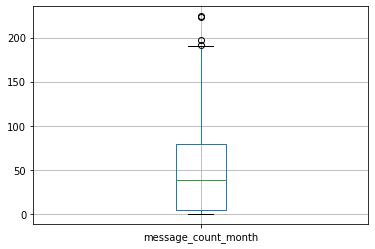

In [30]:
data_ultra.boxplot(column ='message_count_month')

### Вывод исходя из графиков для показателя "количество сообщений в месяц"
* Расчитаны средние, дисперсии, стандартные отклонения для всех значений по двум тарифам.
* Была построена гистограмма по количеству сообщений за месяц для двух тарифов, из графика видно, что дисперсия у тарифа "ultra" больше, то есть количество сообщений разнится больше, чем у более дешевого тарифа "smart". Также из диаграмм размаха видно, что у тарифа "smart" выбросов больше, и большая часть значений сосредоточена в меньшем количестве сообщений, чем у тарифа "ultra".

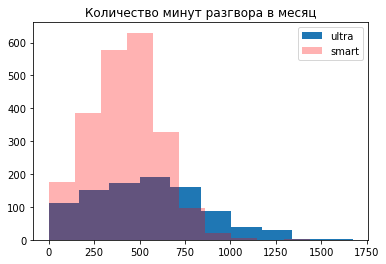

In [42]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(data_ultra['count_min_month'].values)
_ = ax.hist(data_smart['count_min_month'].values, color='red', alpha=.3)
_ = ax.legend(['ultra', 'smart'])
_ = ax.set_title('Количество минут разгвора в месяц')

<AxesSubplot:>

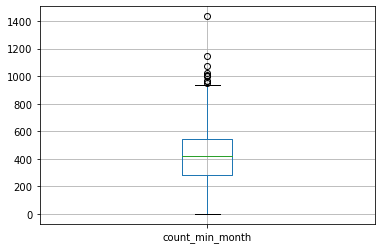

In [43]:
data_smart.boxplot(column ='count_min_month')

<AxesSubplot:>

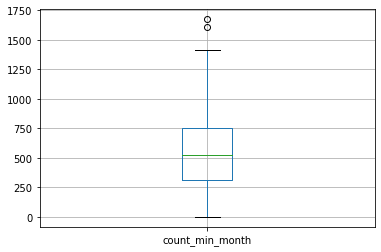

In [44]:
data_ultra.boxplot(column ='count_min_month')

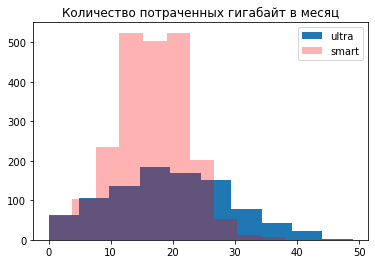

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
_ = ax.hist(data_ultra['gb_count_month'].values)
_ = ax.hist(data_smart['gb_count_month'].values, color='red', alpha=.3)
_ = ax.legend(['ultra', 'smart'])
_ = ax.set_title('Количество потраченных гигабайт в месяц')

<AxesSubplot:>

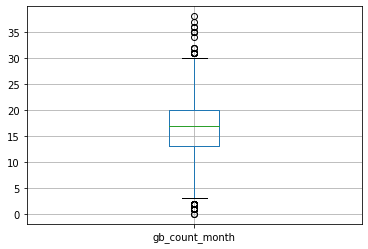

In [46]:
data_smart.boxplot(column ='gb_count_month')

<AxesSubplot:>

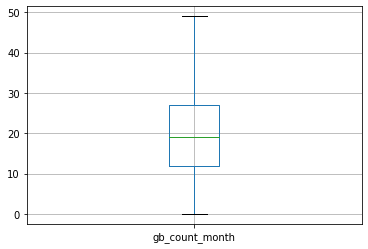

In [47]:
data_ultra.boxplot(column ='gb_count_month')

### Вывод исходя из графиков  для показателей "количество потраченных гигабайт в месяц" и "количество минут разгвора в месяц"
 * Были построены гистограммы "количество потраченных гигабайт в месяц","количество минут разгвора в месяц"  для двух тарифов, из графика видно, что дисперсия у тарифа "ultra" больше.
 * Также из диаграмм размаха видно, что у тарифа "smart" выбросов больше.
 *Вывод: пользователи тарифа "ultra" совершают более разнообразные действия, чем пользователи другого тарифа, а также их средние значения выше(то есть больше отправляют сообщений, дольше говорят и больше тратят гб интернета в месяц). 


---

## Проверка гипотез

**Первая гипотеза:**

* нулевая гипотеза: средняя выручка тарифов «Ультра» и «Смарт» равна
* альтерантивная гипотеза: средняя выручка тарифов «Ультра» и «Смарт» не равна между собой

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind ().
Критический уровень статистической значимости возьмем равным 0.05(alpha = 0.05)


In [48]:
#нулевая гипотеза: средняя выручка тарифов равна
#альтернативная: гипотеза средняя выручка не равна

alpha = 0.05

results1= st.ttest_ind(data_ultra['revenue'],data_smart['revenue'])

print('p-значение:',results1.pvalue)

if (results1.pvalue<alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 2.1830308249112924e-155
Отвергаем нулевую гипотезу


In [49]:
#проверка для большей наглядности(средние значения по столбцам)
data_ultra['revenue'].mean(),data_smart['revenue'].mean()

(2070.9779179810726, 1290.8911381016644)

### Вывод о первой гипотезе
Средняя выручка тарифов «Ультра» и «Смарт» не равна между собой, то есть средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

---

**Вторая гипотеза:**

* нулевая гипотеза: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов
* альтерантивная гипотеза: средняя выручка пользователей из Москвы не равна выручке пользователей из других регионов

Чтобы проверить гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам, применим метод scipy.stats.ttest_ind ().
Критический уровень статистической значимости возьмем равным 0.05(alpha = 0.05)

In [50]:
#нулевая гипотеза: средняя выручка пользователей из Москвы равна выручке пользователей из других регионов.
#альтеранативная: не равна

#данные пользователей из Москвы
data_moscow=data.query('city=="Москва"')

#данные пользователей из других городов(все кроме Москвы)
data_not_moscow=data.query('city!="Москва"')

alpha=0.05

results2=st.ttest_ind(data_not_moscow['revenue'],data_moscow['revenue'])

print('p-значение: ', results2.pvalue)

if results2.pvalue<alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.4619932225305272
Не получилось отвергнуть нулевую гипотезу


In [51]:
#проверка для большей наглядности(средние значения по столбцам)
data_not_moscow['revenue'].mean(),data_moscow['revenue'].mean()

(1519.5237909516381, 1546.0524590163934)

### Вывод о второй гипотезе
Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов, то есть средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов.

## Общий вывод


* Была изучена общая информация о предоставленных данных. 

* Данные были обработаны: все значения были приведены к релевантному типу данных, а также изменены исходя из задачи проекта (округление).

* Для статистического анализа данных были проведены следующие расчеты:  количество сделанных звонков и израсходованных минут разговора по месяцам;количество отправленных сообщений по месяцам;объем израсходованного интернет-трафика по месяцам;помесячную выручку с каждого пользователя.

* Осуществлен статистический анализ данных, используя дисперсию, стандартное отклонение и средние значения для всех количественных показателей.

* Были выдвинуты и проверены две гипотезы: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, из которых следуют следующие выводы:Средняя выручка пользователей из Москвы равна выручке пользователей из других регионов, то есть средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов;Средняя выручка тарифов «Ультра» и «Смарт» не равна между собой, то есть средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются. 
    
**В результате исследования было выявлено, что тариф "ultra" является более выгодным.**

## Вывод из цели
* У тарифа "ultra" средняя выручка выше, чему у тарифа "smart". Все средние показатели за месяц (среднее кол-во минут в месяц, реднее количество потраченных гб в месяц, среднее колиечество отправленыых в месяц сообщений) больше, а также действия более разнообразны, чем у пользователей тарифа "smart".
* Отсюда можно сделать вывод, что тариф "ultra" более выгодный для «Мегалайн». Поэтому затраты на маркетинг для тарифа "smart" следует увеличить, а также пересмотреть политику тарифа "smart"(например: увеличение включенных в тариф услуг(т.к большинство пользователей пользуется услугами сверх тарифа) - и из этого следует увеличение стоимости самого тарифа и как итог увеличение выручки компании.